In [1]:
!pip install -q transformers==2.1.1
!pip install torch
!pip install fastai==1.0.61

     |████████████████████████████████| 311 kB 39.6 MB/s 
     |████████████████████████████████| 880 kB 44.0 MB/s 
     |████████████████████████████████| 1.3 MB 49.2 MB/s 
     |████████████████████████████████| 132 kB 63.3 MB/s 
     |████████████████████████████████| 79 kB 8.3 MB/s 
     |████████████████████████████████| 10.2 MB 53.8 MB/s 
     |████████████████████████████████| 140 kB 96.5 MB/s 
     |████████████████████████████████| 127 kB 67.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 239 kB 12.5 MB/s 
     |████████████████████████████████| 355 kB 39.3 MB/s 
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19190 sha256=d926375c4a65ef444ddf4a56a9f98a0d217d78dea8914a638efa451d7bc89451
  Stored in directory: /root/.cache/pip/wheels/b9/b1/68/c

In [2]:
# reference : https://github.com/huggingface/transformers/blob/main/README.md
# https://towardsdatascience.com/fastai-with-transformers-bert-roberta-xlnet-xlm-distilbert-4f41ee18ecb2
# pretrained model: https://huggingface.co/models#pretrained-models
from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig
import torch
from fastai import *
from fastai.text import *

In [3]:
def preprocess_tweet(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    
    sentence = sen.lower()

    # Remove RT
    sentence = re.sub('RT @\w+: '," ", sentence)

    # Remove Tag
    sentence = re.sub('(#[A-Za-z0-9]+)', '',sentence)

    # Remove special characters
    sentence = re.sub("(@[A-Za-z0-9_]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ", sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [4]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] +  [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens


In [5]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
        
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})



In [6]:
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids):
        # Return only the logits from the transfomer
        logits = self.transformer(input_ids)[0]   
        return logits


In [7]:
model_class, tokenizer_class, config_class = BertForSequenceClassification, BertTokenizer, BertConfig
model_name = 'bert-base-uncased'
model_type = 'bert'

transformer_tokenizer = tokenizer_class.from_pretrained(model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, 
                                       include_bos=False, 
                                       include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

100%|██████████| 231508/231508 [00:00<00:00, 8845179.23B/s]


In [18]:
# read training data
from urllib.request import urlopen

train_url = 'https://raw.githubusercontent.com/abeermohamed1/Tweets-Sentiment-Analysis/master/twitter-2016train.txt'
test_url = "https://raw.githubusercontent.com/abeermohamed1/Tweets-Sentiment-Analysis/master/twitter-2015train.txt"

#url = 'https://raw.githubusercontent.com/FanZang-Allen/PRIVATE_COVID_SENTIMENT/master/labeled_data/gold.json?token=GHSAT0AAAAAABZJMMU7ASNO6LX5732KUS26Y4KO6MA'

def get_data(target_url):
  frame = {'id':[], 'clean_tweet':[], 'sentiment':[]}
  data = urlopen(target_url)
  for line in data: # files are iterable
      line = line.decode('utf-8')
      temp = line.split(maxsplit = 2)
      if len(temp) != 3:
        continue
      frame['id'].append(temp[0])
      if(temp[1]) == 'negative':
          frame['sentiment'].append(-1)
      elif(temp[1]) == 'neutral':
          frame['sentiment'].append(0)
      else:
          frame['sentiment'].append(1)
      frame['clean_tweet'].append(preprocess_tweet(temp[2]))
    
  return pd.DataFrame(frame)

train = get_data(train_url)
test = get_data(test_url)

#from sklearn.model_selection import train_test_split
#data = get_data(url)
#train, test = train_test_split(data, test_size=0.2, random_state=25)
print(test)

                     id                                        clean_tweet  \
0    105121481662541824  i forgot how sad the first episode of the 5th ...   
1    104319460143415296  oct 2 is almost too far away for me to wait fo...   
2    103641916586999808   off topic there is only 3 episodes on the fir...   
3    100544750414864384   is finally catching up to me with m only up t...   
4    102220476499243008   downloaded the first season of gonna start wa...   
..                  ...                                                ...   
484  264204267370450944   cant wait to see flight on saturday u002c den...   
485  264184542305345537  gotta go see flight tomorrow denzel is the gre...   
486  264243526005575680  hey wanna see flight tomorrow with denzel ol f...   
487  264191631325020160  that movie flight with denzel looks really goo...   
488  264204783974490113   mane gotta see that denzel movie tomorrow shi...   

     sentiment  
0           -1  
1           -1  
2           

In [19]:
from transformers import AdamW
from functools import partial


pad_idx = transformer_tokenizer.pad_token_id

databunch = (TextList.from_df(train, cols='clean_tweet', processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=42)
             .label_from_df(cols='sentiment')
             .add_test(test)
             .databunch(bs=16, pad_first=False, pad_idx=pad_idx))

CustomAdamW = partial(AdamW, correct_bias=False)

config = config_class.from_pretrained(model_name)
config.num_labels = 3
transformer_model = model_class.from_pretrained(model_name, config = config)
custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy, error_rate])

/usr/local/lib/python3.8/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.8/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
100%|██████████| 440473133/440473133 [00:06<00:00, 63230681.44B/s]


In [20]:
learner.freeze_to(-1)

In [21]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:166: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1174.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.00E-05
Min loss divided by 10: 6.31E-06


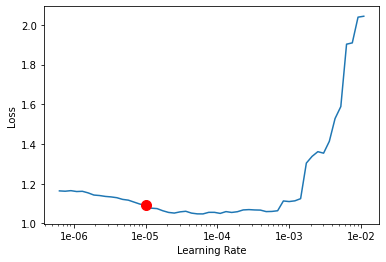

In [22]:
learner.recorder.plot(skip_end=10,suggestion=True)

In [23]:
learner.fit_one_cycle(1,max_lr=1e-05,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.778139,0.746078,0.651667,0.348333,23:11


In [24]:
learner.save('first_cycle')

In [25]:
learner.freeze_to(-2)

In [ ]:
learner.fit_one_cycle(1,max_lr=1e-05,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,error_rate,time


In [ ]:
learner.unfreeze()

In [ ]:
learner.fit_one_cycle(2, max_lr=1e-05, moms=(0.8, 0.9))